
# Notebook Profiling comparison
**Takes a lot of RAM, as the whole cell-level dataset needs to be stored twice in memory and processed for UMAP projections.**  

Chemical screen, single plate at 750 cells per well.  
In this notebook, we create cellular profiles from CellProfiler measurements per cell, filter and transform the morphological data and finally aggregate the data per field of view (image).

In [1]:
using CSV, StatsBase, Statistics, DataFrames, UMAP, RCall, FreqTables
using MultipleTesting, Random, MultivariateStats, Distributed
using BioProfiling
using CategoricalArrays

In [2]:
using Dates: now
now()

2021-10-20T09:33:04.24

## R Calls

In [3]:
@rlibrary ggplot2
@rlibrary extrafont
@rlibrary viridis
@rlibrary heatmaply
@rlibrary ggrepel

In [15]:
R"""
# Used later for MCD computation

library(robustbase)

# Customize ggplot appearance

library(ggplot2)
library(extrafont)


# Load extra fonts
ttf_import("/tmp/.fonts")
loadfonts()

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), 
                     legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)
"""

RObject{VecSxp}
$repr.plot.width
NULL

$repr.plot.height
NULL



## Load measurements

### Load individual cell files

In [5]:
cell = CSV.read("data/compiled_cell_750.csv", DataFrame);

## Experiment filtering

### Keep all cells

In [6]:
xp_unfiltered = Experiment(deepcopy(cell), description = "All measurements for plate @750c/well. No filtering.")

"Experiment with 1706619/1706619 entries and 798/798 features selected."

In [7]:
# Make sure to remove columns that are not morphological measurements
strToRemove = ["Parent", "ObjectNumber", "ImageNumber", "Experiment",
                "Object_Number", "Location", "Center", "Metadata", "Orientation",
                "PlateNumber", "CompoundName", "Texture", "Neighbors_AngleBetweenNeighbors_5",
                "Neighbors_SecondClosestDistance_5", "URL"]
# NB: Textural features have missing values
filters = Array{BioProfiling.AbstractReduce}([NameSelector(x -> !any(occursin.(strToRemove, String(x))))])

1-element Array{BioProfiling.AbstractReduce,1}:
 NameSelector(var"#1#2"(), "No description provided")

In [8]:
select!(xp_unfiltered, filters)

In [9]:
# No measurements are missing!
tdf = getdata(xp_unfiltered)
@assert sum(Array(mapcols(x -> sum(ismissing.(x)), tdf))[1,:]) == 0
# Free up memory
tdf = nothing

In [10]:
xp_unfiltered

"Experiment with 1706619/1706619 entries and 385/798 features selected."

In [11]:
logtransform!(xp_unfiltered)

1706619×385 SubDataFrame
     Row │ AreaShape_Area  AreaShape_Compactness  AreaShape_Eccentricity  Area ⋯
         │ Float64         Float64                Float64                 Floa ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │        6.65415              0.0430126                0.351953       ⋯
       2 │        8.40425              0.512657                 0.637428
       3 │        6.72743              0.0976871                0.470425
       4 │        8.37655              0.473246                 0.586493
       5 │        6.88857              0.112528                 0.539293       ⋯
       6 │        6.71901              0.0468458                0.389592
       7 │        6.3315               0.132151                 0.54374
       8 │        7.18387              0.168966                 0.560433
       9 │        9.31812              0.212704                 0.551496       ⋯
      10 │        8.65939              1.20735                  0.669359
      11 │        6.92854              0.0199305                0.361108
    ⋮    │       ⋮                   ⋮                      ⋮                  ⋱
 1706610 │        7.34084              0.25916                  0.600381
 1706611 │        7.03174              0.130766                 0.518023       ⋯
 1706612 │        6.81014              0.0689767                0.411094
 1706613 │        7.50108              0.111554                 0.528849
 1706614 │        6.85435              0.299449                 0.60884
 1706615 │        7.67183              0.0552929                0.449478       ⋯
 1706616 │        6.19644              0.324657                 0.604945
 1706617 │        7.41095              0.0912099                0.455671
 1706618 │        7.37212              0.0875246                0.507926
 1706619 │        5.38907              0.221807                 0.494975       ⋯
                                            382 columns and 1706598 rows omitted

In [12]:
decorrelate_by_mad!(xp_unfiltered);

In [ ]:
stime = now()
Random.seed!(3895)
umTPM = umap(xp_unfiltered)
umTPM = convert(DataFrame, umTPM')
rename!(umTPM, [:UMAP1, :UMAP2]);
umTPM.Compound = xp_unfiltered.data[xp_unfiltered.selected_entries, :CompoundName]
now() - stime

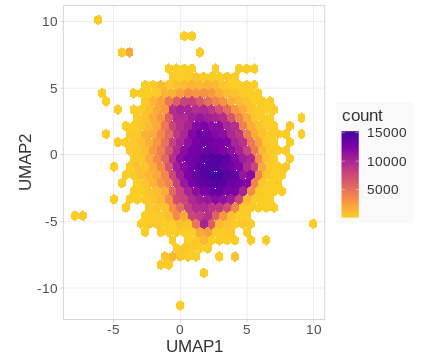

RObject{VecSxp}


In [16]:
ggplot(umTPM, aes(x = :UMAP1, y = :UMAP2)) +
    geom_hex() +
    coord_fixed() +
    RObject(nothing)

### Remove cells identified as bad (see notebook Fig2a)

In [17]:
xp = Experiment(deepcopy(cell), description = "All measurements for plate @750c/well.")

"Experiment with 1706619/1706619 entries and 798/798 features selected."

In [18]:
# Make sure to remove columns that are not morphological measurements
strToRemove = ["Parent", "ObjectNumber", "ImageNumber", "Experiment",
                "Object_Number", "Location", "Center", "Metadata", "Orientation",
                "PlateNumber", "CompoundName", "Texture", "Neighbors_AngleBetweenNeighbors_5",
                "Neighbors_SecondClosestDistance_5", "URL"]
# NB: Textural features have missing values
filters = Array{BioProfiling.AbstractReduce}([NameSelector(x -> !any(occursin.(strToRemove, String(x))))])

1-element Array{BioProfiling.AbstractReduce,1}:
 NameSelector(var"#5#6"(), "No description provided")

In [19]:
xp.data.Metadata_Ratio1 = xp.data.AreaShape_Area_1 ./ xp.data.AreaShape_Area_2
push!(filters, Filter(4, :Metadata_Ratio1, 
        compare = <, 
        description = "Exclude cells with really large cytoCM"));

In [20]:
xp.data.Metadata_Ratio2 = xp.data.AreaShape_Area ./ xp.data.AreaShape_Area_1
push!(filters, Filter(10, :Metadata_Ratio2, compare = <, 
        description = "Exclude cells with really large cytoplasm"));

In [21]:
push!(filters, Filter(0.5, :AreaShape_FormFactor_2, compare = >, description = "Keep roundish nuclei"));

In [22]:
push!(filters, Filter(0.1, :Intensity_MaxIntensity_CorrCM_1, compare = <, 
        description = "Exclude unsually bright CM"));

In [23]:
select!(xp, filters)

In [24]:
# No measurements are missing!
tdf = getdata(xp)
@assert sum(Array(mapcols(x -> sum(ismissing.(x)), tdf))[1,:]) == 0
# Free up memory
tdf = nothing

```julia
# Remove constant columns
push!(filters, Selector(x -> mad(x, normalize = true) != 0, description = "Remove constant features"));
push!(filters, Selector(x -> mad(x, normalize = true) != 0, 
                        subset = x -> x.CompoundName .== "DMSO", 
                        description = "Remove features constant for reference"));
```

In [25]:
xp

"Experiment with 1631340/1706619 entries and 385/800 features selected."

### Subset data to images with at least 3 cells

In [26]:
cell_per_image = freqtable(xp.data[xp.selected_entries,:ImageNumber])
non_sparse_images = Set(k for (k,v) in cell_per_image.dicts[1] if cell_per_image.array[v] >= 3);

In [27]:
compare_in(x,y) = x in y
Broadcast.broadcasted(::typeof(compare_in), x, y) = broadcast(in, x, Ref(y))
sparcity_filter = Filter(non_sparse_images, :ImageNumber, compare = compare_in)

Filter(Set([6928, 11532, 6380, 1316, 5842, 15004, 8312, 4460, 13120, 14400  …  13874, 2224, 6574, 11614, 13714, 14086, 14232, 12736, 3076, 9366]), :ImageNumber, compare_in, "No description provided")

In [28]:
filter_entries!(xp, sparcity_filter);

In [29]:
xp

"Experiment with 1631151/1706619 entries and 385/800 features selected."

In [30]:
umTPM[!, :Filtered] .= "Filtered cell"
umTPM.Filtered[xp.selected_entries] .= "Kept cell";

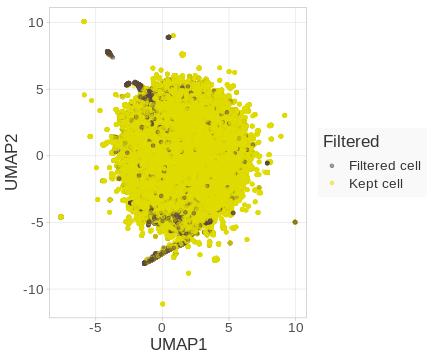

RObject{VecSxp}


In [31]:
ggplot(umTPM, aes(x = :UMAP1, y = :UMAP2, color = :Filtered)) +
    geom_point(alpha = 0.5) +
    coord_fixed() +
    RObject(nothing)

In [263]:
e = Experiment(umTPM)
e.data.URL = cell.URL
# Make a row ID field
e.data.ID = 1:size(e.data, 1);

In [266]:
# Add cell centers
e.data = hcat(e.data, cell[:, [:AreaShape_Center_X, 
                               :AreaShape_Center_Y, 
                               :AreaShape_Center_X_1, 
                               :AreaShape_Center_Y_1]]);

In [267]:
# The following cells are used to illustrate clusters
idcell = [876, 6277, 7205, 3839, 10163, 10781]
exfilter = Filter(idcell, :ID, compare = compare_in)

Filter([876, 6277, 7205, 3839, 10163, 10781], :ID, compare_in, "No description provided")

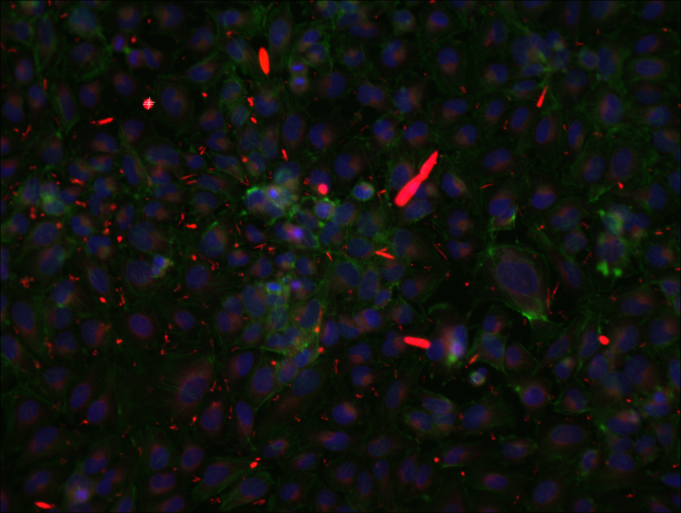

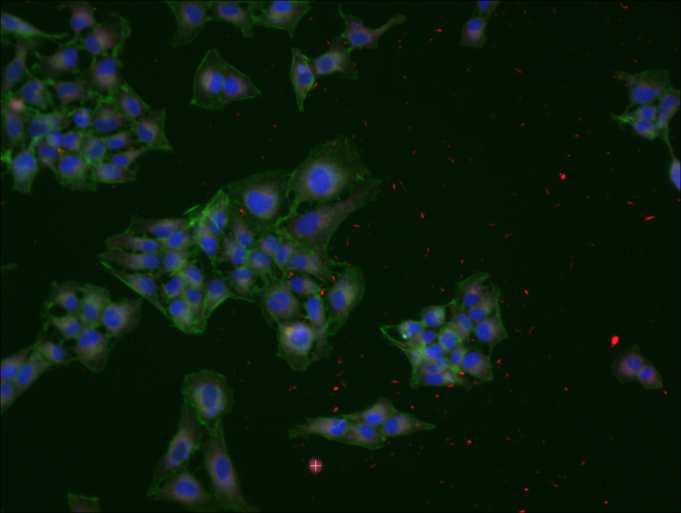

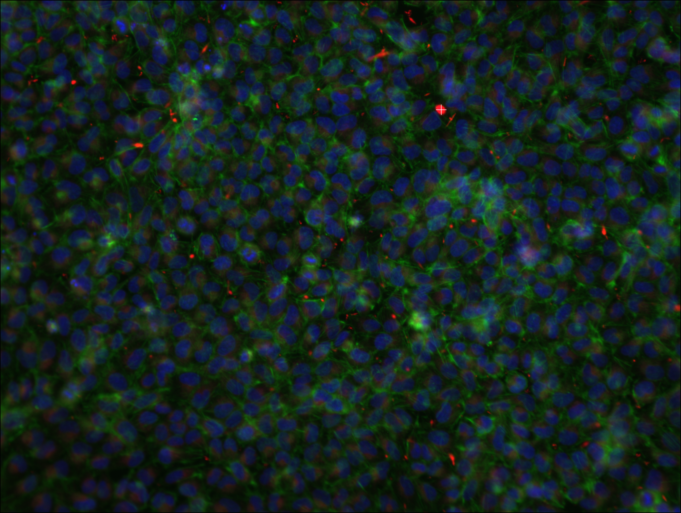

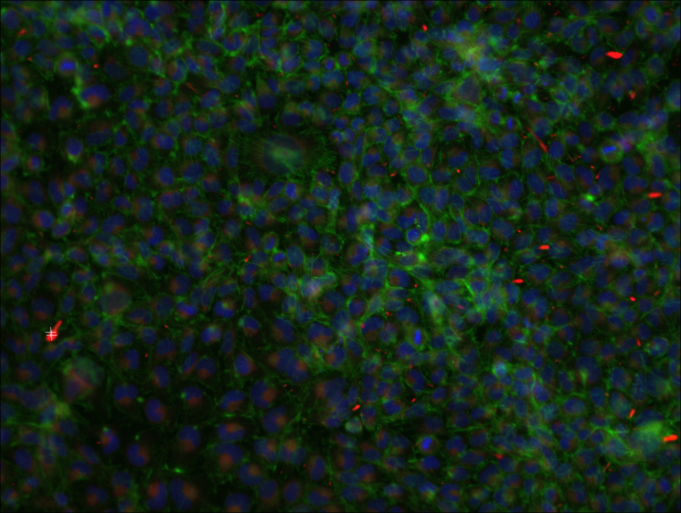

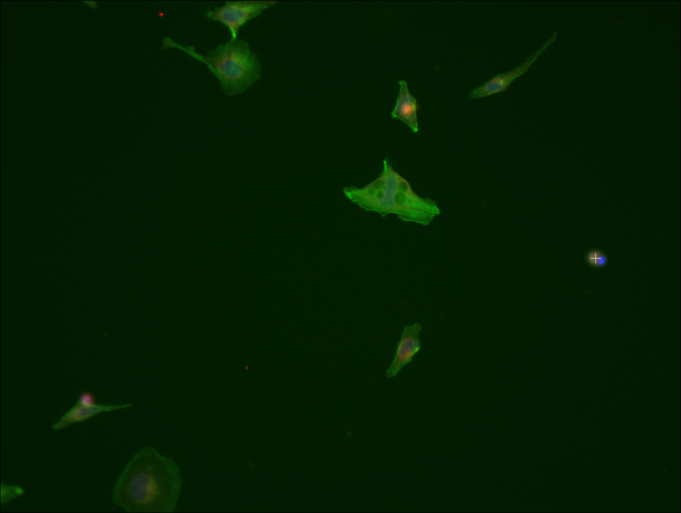

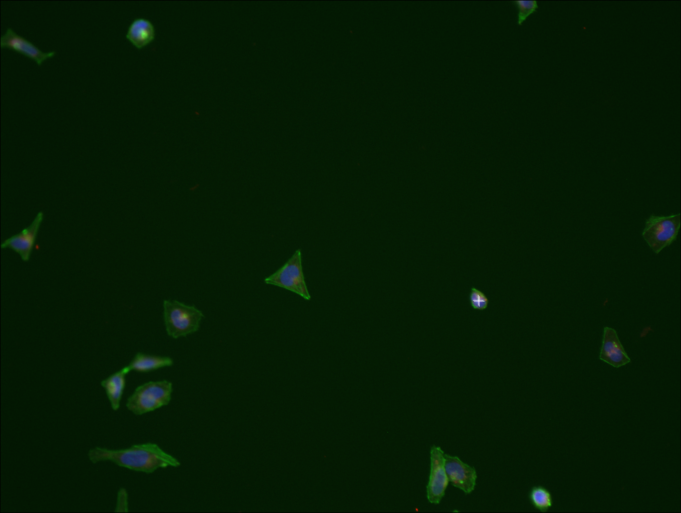

true

In [270]:
diagnostic_images(e, exfilter, :URL, 
                    saveimages = true, show = true,
                    rgb = rgbrgx, showlimit = 10, center = true)

In [272]:
umTPM[!, :Label] .= [id in idcell ? id : "" for id in umTPM.ID];

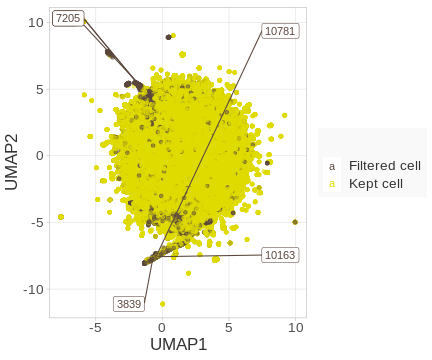

RObject{VecSxp}


In [283]:
gp = ggplot(umTPM, aes(x = :UMAP1, y = :UMAP2, color = :Filtered)) +
    geom_point(alpha = 0.5) +
    geom_label_repel(aes(label = :Label), var"max.overlaps" = 10000) +
    coord_fixed() +
    guides(shape = false, color = guide_legend(title="")) +
    RObject(nothing)

In [284]:
ggsave("fig/Benchmark_filtering.pdf", gp)

LoadError: REvalError: Saving 7 x 7 in image
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)) :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Warning in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  :
  font family 'Arial' not found in PostScript font database
Error in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y,  : 
  invalid font type
Calls: <Anonymous> ... drawDetails -> drawDetails.text -> grid.Call.graphics

Note: because there are so many points, the resulting PDF is very heavy and hard to work with. We recommend exporting it as PNG or using `ggrastr` on the `geom_point` layer.

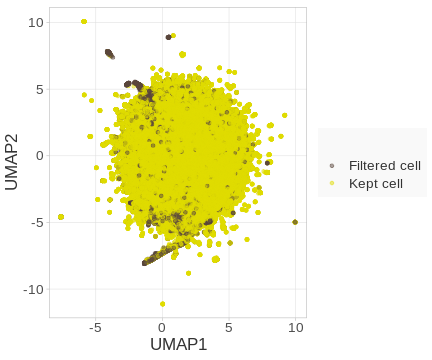

RObject{VecSxp}


In [290]:
gp = ggplot(umTPM, aes(x = :UMAP1, y = :UMAP2, color = :Filtered)) +
    geom_point(alpha = 0.5) +
    coord_fixed() +
    guides(shape = false, color = guide_legend(title="")) +
    RObject(nothing)

In [291]:
ggsave("fig/Benchmark_filtering.png", gp)

┌ Warning: RCall.jl: Saving 7 x 7 in image
└ @ RCall /opt/julia/packages/RCall/iMDW2/src/io.jl:160


RObject{NilSxp}
NULL


876

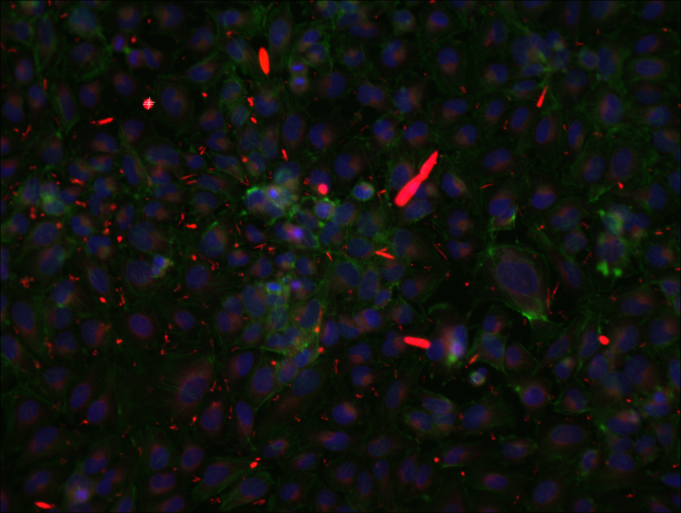

"======"

6277

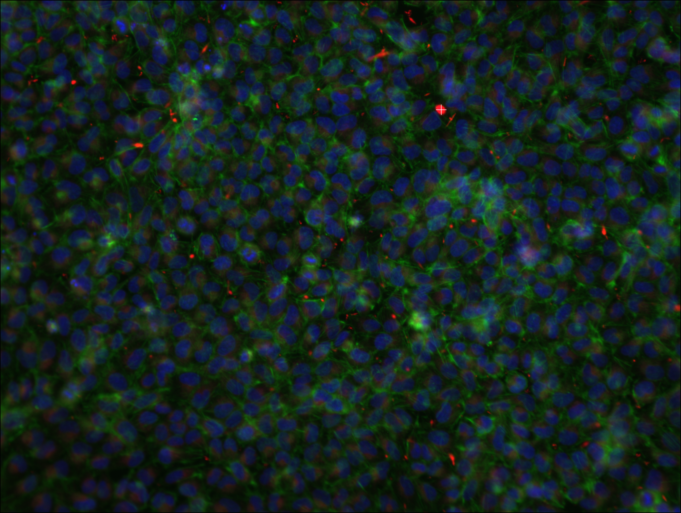

"======"

7205

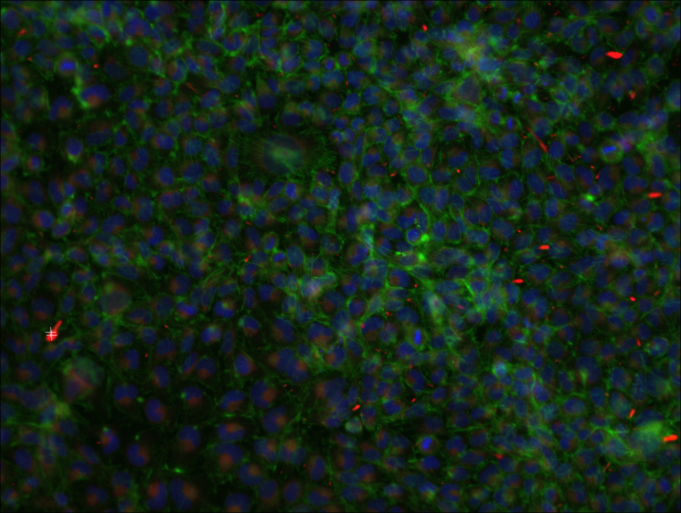

"======"

3839

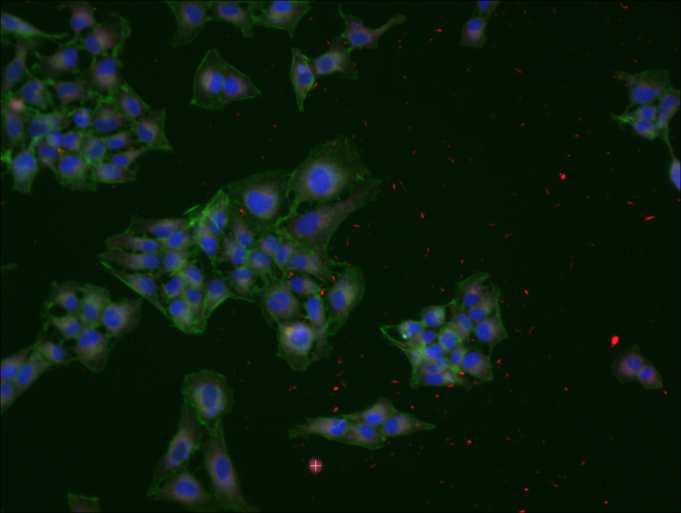

"======"

10163

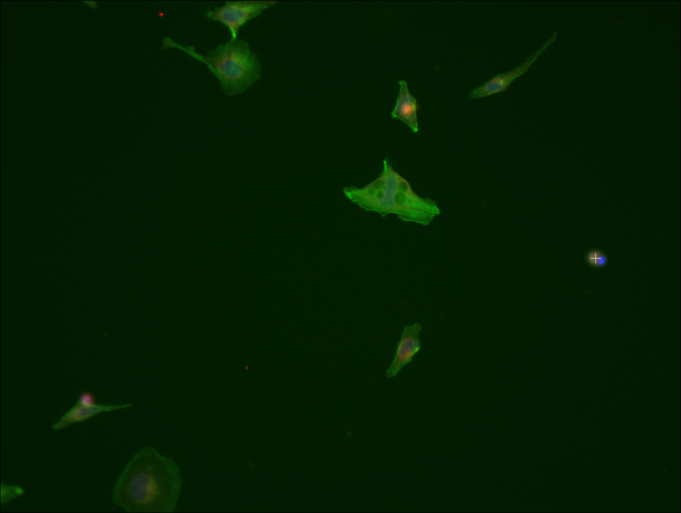

"======"

10781

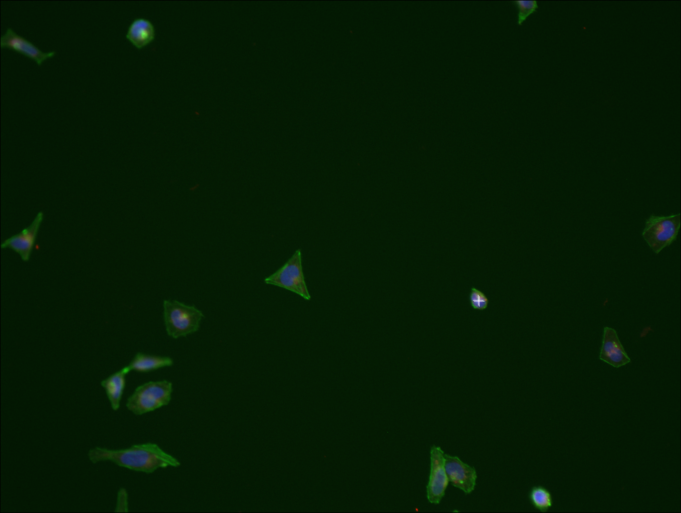

"======"

In [288]:
# Here we make sure of the ordering of the images
for id in idcell
    fcell = Filter(id, :ID)
    display(id)
    diagnostic_images(e, fcell, :URL, 
                        saveimages = false, show = true,
                        rgb = rgbrgx, showlimit = 10, center = true)
    display("======")
end